In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
import random
from datetime import datetime, timedelta
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import seaborn as sns

from google.colab import files

from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.grid_finder as gf
import mpl_toolkits.axisartist.floating_axes as fa

In [40]:
# Performance metrics

def nash_sutcliffe_efficiency(observed, simulated):
    obs_mean = np.mean(observed)
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - obs_mean) ** 2)

    nse = 1 - (numerator / denominator)
    return nse

def calculate_rmse(observed, predicted):

    rmse = np.sqrt(np.mean((observed - predicted)**2))
    return rmse

def calculate_r2(observed, predicted):

    mean_observed = np.mean(observed)
    mean_predicted = np.mean(predicted)

    numerator = np.sum((observed - mean_observed) * (predicted - mean_predicted))
    denominator = np.sqrt(np.sum((observed - mean_observed)**2)) * np.sqrt(np.sum((predicted - mean_predicted)**2))

    r2 = (numerator / denominator)**2
    return r2

def calculate_mae(observed, predicted):
    mae = np.mean(np.abs(observed - predicted))
    return mae

def calculate_ca(rmse, mae, r2):
    ca = 0.33 * (rmse + mae + (1 - r2))
    return ca


SAVÈ

In [41]:
# #Import predicted data, initially saved

daily = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/HINNs/savè.xlsx')
discharge1 = daily.iloc[1280:, 0].to_numpy()

hymolap = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/HyMoLAP/Paper/Hym_savè1.xlsx')
hymolap1 = hymolap.iloc[:, 0].to_numpy()

hymolap = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/HyMoLAP/Paper/Hym_savè2.xlsx')
hymolap2 = hymolap.iloc[:, 0].to_numpy()

hymolap = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/HyMoLAP/Paper/Hym_savè3.xlsx')
hymolap3 = hymolap.iloc[:, 0].to_numpy()

gr6j = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/HyMoLAP/Paper/GR6J_savè.xlsx')
GR6J = gr6j.iloc[:, 0].to_numpy()


In [42]:
len(discharge1), len(hymolap1), len(hymolap2), len(hymolap3), len(GR6J)

(730, 730, 730, 730, 730)

Taylor Diagram

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

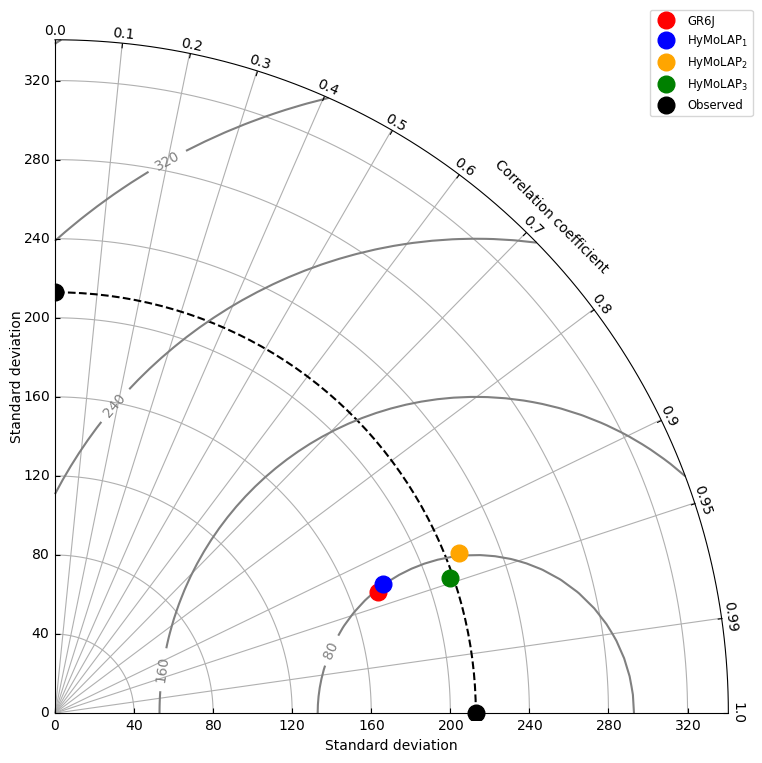

In [43]:
class TaylorDiagram(object):
    def __init__(self, STD, fig=None, rect=111, label='_'):
        self.STD = STD
        tr = PolarAxes.PolarTransform()

        # Correlation labels
        rlocs = np.concatenate(((np.arange(11.0) / 10.0), [0.95, 0.99]))
        tlocs = np.arccos(rlocs)  # Conversion to polar angles
        gl1 = gf.FixedLocator(tlocs)  # Positions
        tf1 = gf.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

        # Standard deviation axis extent
        self.smin = 0
        self.smax = 1.6 * self.STD

        gh = fa.GridHelperCurveLinear(
            tr,
            extremes=(0, (np.pi / 2), self.smin, self.smax),
            grid_locator1=gl1,
            tick_formatter1=tf1,
        )

        if fig is None:
            fig = plt.figure()
        ax = fa.FloatingSubplot(fig, rect, grid_helper=gh)
        fig.add_subplot(ax)

        # Angle axis
        ax.axis['top'].set_axis_direction('bottom')
        ax.axis['top'].label.set_text("Correlation coefficient")
        ax.axis['top'].toggle(ticklabels=True, label=True)
        ax.axis['top'].major_ticklabels.set_axis_direction('top')
        ax.axis['top'].label.set_axis_direction('top')

        # X axis
        ax.axis['left'].set_axis_direction('bottom')
        ax.axis['left'].label.set_text("Standard deviation")
        ax.axis['left'].toggle(ticklabels=True, label=True)
        #ax.axis['left'].label.set_pad(-1.5)  # Espacement entre l'axe et le titre (ajout de marge)
        ax.axis['left'].major_ticklabels.set_axis_direction('bottom')
        ax.axis['left'].label.set_axis_direction('bottom')

        # Y axis
        ax.axis['right'].set_axis_direction('top')
        ax.axis['right'].label.set_text("Standard deviation")
        ax.axis['right'].toggle(ticklabels=True, label=True)
        ax.axis['right'].label.set_pad(-1.)  # Espacement entre l'axe et le titre (ajout de marge)
        ax.axis['right'].major_ticklabels.set_axis_direction('left')
        ax.axis['right'].label.set_axis_direction('top')

        # Disable the bottom axis
        ax.axis['bottom'].set_visible(False)

        ax.grid()

        self._ax = ax  # Graphical axes
        self.ax = ax.get_aux_axes(tr)  # Polar coordinates

        # Add reference point and STD contour
        l, = self.ax.plot([0], self.STD, 'o', ls='', color='black', ms=12, label=label)
        t = np.linspace(0, np.pi / 2)
        r = np.zeros_like(t) + self.STD
        self.ax.plot(t, r, 'k--', label='_')
        self.samplePoints = [l]

    def add_sample(self, STD, r, *args, **kwargs):
        l, = self.ax.plot(np.arccos(r), STD, *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)
        return l

    def add_contours(self, levels=5, **kwargs):
        rs, ts = np.meshgrid(
            np.linspace(self.smin, self.smax), np.linspace(0, np.pi / 2)
        )
        RMSE = np.sqrt(
            np.power(self.STD, 2) + np.power(rs, 2) - (2.0 * self.STD * rs * np.cos(ts))
        )
        contours = self.ax.contour(ts, rs, RMSE, levels, **kwargs)
        return contours

def srl(obsSTD, models, correlations, labels, fname):
    fig = plt.figure(figsize=(7.5, 7.5))
    dia = TaylorDiagram(obsSTD, fig=fig, rect=111, label='Observed')  # Reference point

    plt.clabel(dia.add_contours(colors='#808080'), inline=1, fontsize=10)

    colors = ["red", "blue", "orange", "green"]

    dia.samplePoints = []  # Reset sample points for clean legend
    for std, corr, label, color in zip(models['std'], correlations, labels, colors):
        dia.add_sample(std, corr, label=label, marker='o', color=color, markersize=12, linestyle='')

    # Include the "Observed" reference in the legend
    fig.legend(
        dia.samplePoints + [dia._ax.plot([0], [obsSTD], 'o', color='black', ms=12, label='Observed')[0]],
        [p.get_label() for p in dia.samplePoints] + ['Observed'],
        numpoints=1, prop=dict(size='small'), loc='upper right', bbox_to_anchor=(1, 1)
    )

    plt.tight_layout()
    plt.savefig("TaylorS.png", format='png', dpi=500)

    # Download the file to your laptop
    files.download("TaylorS.png")

    plt.show()



# Données à partir de discharge1 et models
observed = discharge1
models = {
    "GR6J": GR6J,
    "HyMoLAP$_1$": hymolap1,
    "HyMoLAP$_2$": hymolap2,
    "HyMoLAP$_3$": hymolap3,
}

std_obs = np.std(observed)
stats = []
for model_name, model_values in models.items():
    std_model = np.std(model_values)
    correlation = np.corrcoef(observed, model_values)[0, 1]
    stats.append((std_model, correlation, model_name))

std_models, correlations, labels = zip(*stats)

# Appeler la fonction pour tracer
fname = 'TaylorDiagram.jpg'
srl(std_obs, {'std': std_models}, correlations, labels, fname)


In [44]:
np.std(discharge1)

212.89619225611736

YALA

In [45]:
#Import predicted data, initially saved

yala = pd.read_excel('/content/drive/MyDrive/Prof Mwangi/Qdaily_1FG01_Yala_2014_2020.xlsx')
daily = yala.iloc[:, [-4, -3, -2]]
discharge1 = daily.iloc[1461:2191, 2].to_numpy()

hymolap = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/HyMoLAP/Paper/Hym_yala1.xlsx')
hymolap1 = hymolap.iloc[:, 0].to_numpy()

hymolap = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/HyMoLAP/Paper/Hym_yala2.xlsx')
hymolap2 = hymolap.iloc[:, 0].to_numpy()

hymolap = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/HyMoLAP/Paper/Hym_yala3.xlsx')
hymolap3 = hymolap.iloc[:, 0].to_numpy()

gr6j = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/HyMoLAP/Paper/GR6J_yala.xlsx')
GR6J = gr6j.iloc[:, 0].to_numpy()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

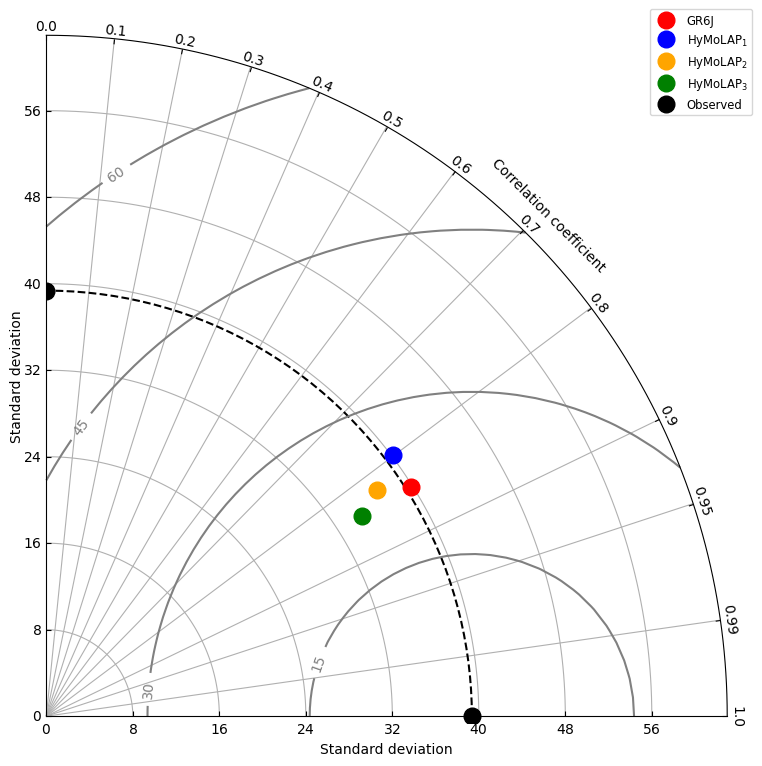

In [46]:
class TaylorDiagram(object):
    def __init__(self, STD, fig=None, rect=111, label='_'):
        self.STD = STD
        tr = PolarAxes.PolarTransform()

        # Correlation labels
        rlocs = np.concatenate(((np.arange(11.0) / 10.0), [0.95, 0.99]))
        tlocs = np.arccos(rlocs)  # Conversion to polar angles
        gl1 = gf.FixedLocator(tlocs)  # Positions
        tf1 = gf.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

        # Standard deviation axis extent
        self.smin = 0
        self.smax = 1.6 * self.STD

        gh = fa.GridHelperCurveLinear(
            tr,
            extremes=(0, (np.pi / 2), self.smin, self.smax),
            grid_locator1=gl1,
            tick_formatter1=tf1,
        )

        if fig is None:
            fig = plt.figure()
        ax = fa.FloatingSubplot(fig, rect, grid_helper=gh)
        fig.add_subplot(ax)

        # Angle axis
        ax.axis['top'].set_axis_direction('bottom')
        ax.axis['top'].label.set_text("Correlation coefficient")
        ax.axis['top'].toggle(ticklabels=True, label=True)
        ax.axis['top'].major_ticklabels.set_axis_direction('top')
        ax.axis['top'].label.set_axis_direction('top')

        # X axis
        ax.axis['left'].set_axis_direction('bottom')
        ax.axis['left'].label.set_text("Standard deviation")
        ax.axis['left'].toggle(ticklabels=True, label=True)
        #ax.axis['left'].label.set_pad(-1.5)  # Espacement entre l'axe et le titre (ajout de marge)
        ax.axis['left'].major_ticklabels.set_axis_direction('bottom')
        ax.axis['left'].label.set_axis_direction('bottom')

        # Y axis
        ax.axis['right'].set_axis_direction('top')
        ax.axis['right'].label.set_text("Standard deviation")
        ax.axis['right'].toggle(ticklabels=True, label=True)
        ax.axis['right'].label.set_pad(-1.)  # Espacement entre l'axe et le titre (ajout de marge)
        ax.axis['right'].major_ticklabels.set_axis_direction('left')
        ax.axis['right'].label.set_axis_direction('top')

        # Disable the bottom axis
        ax.axis['bottom'].set_visible(False)

        ax.grid()

        self._ax = ax  # Graphical axes
        self.ax = ax.get_aux_axes(tr)  # Polar coordinates

        # Add reference point and STD contour
        l, = self.ax.plot([0], self.STD, 'o', ls='', color='black', ms=12, label=label)
        t = np.linspace(0, np.pi / 2)
        r = np.zeros_like(t) + self.STD
        self.ax.plot(t, r, 'k--', label='_')
        self.samplePoints = [l]

    def add_sample(self, STD, r, *args, **kwargs):
        l, = self.ax.plot(np.arccos(r), STD, *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)
        return l

    def add_contours(self, levels=5, **kwargs):
        rs, ts = np.meshgrid(
            np.linspace(self.smin, self.smax), np.linspace(0, np.pi / 2)
        )
        RMSE = np.sqrt(
            np.power(self.STD, 2) + np.power(rs, 2) - (2.0 * self.STD * rs * np.cos(ts))
        )
        contours = self.ax.contour(ts, rs, RMSE, levels, **kwargs)
        return contours

def srl(obsSTD, models, correlations, labels, fname):
    fig = plt.figure(figsize=(7.5, 7.5))
    dia = TaylorDiagram(obsSTD, fig=fig, rect=111, label='Observed')  # Reference point

    plt.clabel(dia.add_contours(colors='#808080'), inline=1, fontsize=10)

    colors = ["red", "blue", "orange", "green"]

    dia.samplePoints = []  # Reset sample points for clean legend
    for std, corr, label, color in zip(models['std'], correlations, labels, colors):
        dia.add_sample(std, corr, label=label, marker='o', color=color, markersize=12, linestyle='')

    # Include the "Observed" reference in the legend
    fig.legend(
        dia.samplePoints + [dia._ax.plot([0], [obsSTD], 'o', color='black', ms=12, label='Observed')[0]],
        [p.get_label() for p in dia.samplePoints] + ['Observed'],
        numpoints=1, prop=dict(size='small'), loc='upper right', bbox_to_anchor=(1, 1)
    )

    plt.tight_layout()
    plt.savefig("TaylorY.png", format='png', dpi=500)

    # Download the file to your laptop
    files.download("TaylorY.png")

    plt.show()



# Données à partir de discharge1 et models
observed = discharge1
models = {
    "GR6J": GR6J,
    "HyMoLAP$_1$": hymolap1,
    "HyMoLAP$_2$": hymolap2,
    "HyMoLAP$_3$": hymolap3,
}

std_obs = np.std(observed)
stats = []
for model_name, model_values in models.items():
    std_model = np.std(model_values)
    correlation = np.corrcoef(observed, model_values)[0, 1]
    stats.append((std_model, correlation, model_name))

std_models, correlations, labels = zip(*stats)

# Appeler la fonction pour tracer
fname = 'TaylorDiagram.jpg'
srl(std_obs, {'std': std_models}, correlations, labels, fname)
